In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps, get_scipy_selected_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss, kalo_objective
from network import null_graph, get_alphas
from related_works import alternating_colearning
from optimization import kalo_graph_discovery, gd_reg_local_FW, local_FW, global_regularized_local_FW, centralized_FW
from utils import load_computer, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 10000
n = 28

MU = 10
BETA = 1

X, Y, X_test, Y_test, K, max_nb_instances = load_computer(path="../datasets/")
D = X[0].shape[1]

# get nodes
nodes = null_graph(X, Y, X_test, Y_test, K, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
    'edges': [edges, []]
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D, min_v=vmin, max_v=vmax)

results = {}

In [3]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Global-Adaboost"] = {}
results["Global-Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["Global-Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
results["Local-Adaboost"] = {}
results["Local-Adaboost"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["Local-Adaboost"]["test-accuracy"] = central_test_accuracy(local_nodes)

In [4]:
MU, LA = 10, 10
STEP = 1000

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
}

gd_nodes = deepcopy(nodes)

results["Dada-Learned"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": STEP, 
    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

# Accuracy and Convergence

/home/valentina/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


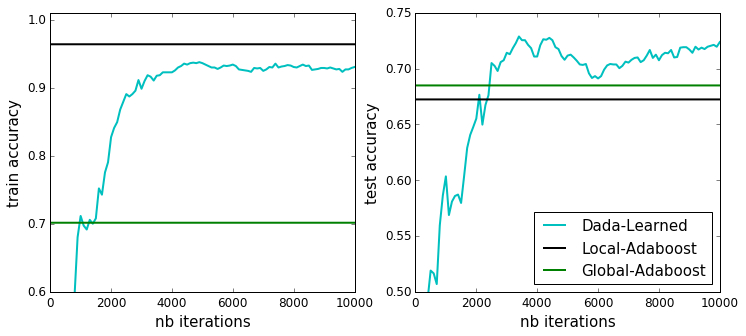

In [6]:
colors = {
    "Global-Adaboost": "g",
    "Local-Adaboost": "k",
    "Dada-Fixed": "b",
    "Perso-linear-Fixed": "m", 
    "Dada-Learned": "c",    
    "Dada-Random": "r",
}

plt.figure(1, figsize=(12, 5))

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('train accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.6, 1.01)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():
    label = k
    label = '_nolegend_'
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=15)
plt.ylabel('test accuracy', fontsize=15)
plt.xlim(0, max_iter)
plt.ylim(0.5, 0.75)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

for k, r_list in results.items():

    label = '{}'.format(k)
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=15)

plt.savefig("computers-acc.pdf", bbox_inches="tight")